<a href="https://colab.research.google.com/github/SangaviGR/TROAD/blob/main/TROAD1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install praw nltk empath pandas prefixspan asyncpraw emoji tabulate plotly

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

In [3]:
import praw
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from empath import Empath
from prefixspan import PrefixSpan
from collections import defaultdict
from datetime import datetime, timedelta
import emoji
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# Initialize Empath for emotion analysis
lexicon = Empath()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    emojis = emoji.distinct_emoji_list(text)
    for em in emojis:
        text = text.replace(em, emoji.demojize(em))
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(stemmer.stem(word)) for word in tokens]
    return ' '.join(tokens)

# Reddit API Setup
reddit = praw.Reddit(
   client_id="A8U6rN952MneQmUhWXSKyw",
    client_secret="V4C5yNDyO9Ez1jq2Osj-zAUy7-Xj7g",
    user_agent="test_script"
)

subreddit = reddit.subreddit("depression")
user_data = defaultdict(lambda: {'posts': [], 'comments': []})

def extract_emotions(text):
    processed_text = preprocess_text(text)
    if not processed_text.strip():
        return []
    tokens = word_tokenize(processed_text)
    emotion_scores = lexicon.analyze(" ".join(tokens), normalize=True) or {}
    top_emotions = [emotion for emotion, score in emotion_scores.items() if score > 0.2]
    return top_emotions

for submission in subreddit.top(limit=250):
    author = submission.author
    if author:
        user_data[author]['posts'].append({'text': preprocess_text(submission.selftext), 'date': submission.created_utc})
    submission.comments.replace_more(limit=0)
    for comment in submission.comments.list():
        if comment.author:
            user_data[comment.author]['comments'].append({'text': preprocess_text(comment.body), 'date': comment.created_utc})

min_active_days = 15
filtered_users = {}
for user, activity in user_data.items():
    post_dates = {datetime.utcfromtimestamp(p['date']).date() for p in activity['posts']}
    comment_dates = {datetime.utcfromtimestamp(c['date']).date() for c in activity['comments']}
    active_days = post_dates | comment_dates
    if len(active_days) >= min_active_days:
        filtered_users[user] = activity

window_sizes = [1, 2, 3, 4, 5]

def analyze_patterns(filtered_users, include_silence=False):
    sequential_patterns = {}
    silent_threshold = timedelta(days=3)

    for window_size in window_sizes:
        patterns = []
        for user, activity in filtered_users.items():
            sorted_activity = sorted(activity['posts'] + activity['comments'], key=lambda x: x['date'])
            emotions_sequence = []
            last_date = None

            for entry in sorted_activity:
                curr_date = datetime.utcfromtimestamp(entry['date'])
                if include_silence and last_date and (curr_date - last_date) > silent_threshold:
                    emotions_sequence.append(['silence'])
                emotions_sequence.append(extract_emotions(entry['text']))
                last_date = curr_date

            emotions_sequence = [e for e in emotions_sequence if e]
            for i in range(len(emotions_sequence) - window_size + 1):
                window = emotions_sequence[i:i + window_size]
                flat_window = [emotion for sublist in window for emotion in sublist]
                patterns.append(flat_window)

        ps = PrefixSpan(patterns)
        frequent_patterns = ps.frequent(3)
        sequential_patterns[window_size] = frequent_patterns

    return sequential_patterns

# Analyze patterns without and with silent periods
patterns_without_silence = analyze_patterns(filtered_users, include_silence=False)
patterns_with_silence = analyze_patterns(filtered_users, include_silence=True)

def compute_confidence(pattern, support_count, pattern_support):
    if len(pattern) < 2:
        return 1.0  # Single-item patterns have 100% confidence
    prefix = tuple(pattern[:-1])
    prefix_support = pattern_support.get(prefix, support_count)
    return support_count / prefix_support if prefix_support > 0 else 0

def compute_sequential_confidence(pattern, support_count, pattern_support):
    if len(pattern) < 2:
        return None
    first_item = tuple([pattern[0]])
    first_item_support = pattern_support.get(first_item, support_count)
    return support_count / first_item_support if first_item_support > 0 else 0

def display_patterns(patterns, title):
    print(f"\n🔹 {title}")
    for w, frequent_patterns in patterns.items():
        pattern_support = {tuple(s[1]): s[0] for s in frequent_patterns}
        table_data = []
        for support, pattern in frequent_patterns:
            confidence = compute_confidence(pattern, support, pattern_support)
            sequential_confidence = compute_sequential_confidence(pattern, support, pattern_support)
            table_data.append([
                ", ".join(pattern),
                support,
                round(confidence, 3) if confidence is not None else "N/A",
                round(sequential_confidence, 3) if sequential_confidence is not None else "N/A"
            ])
        table_data_sorted = sorted(table_data, key=lambda x: (x[3] != "N/A", x[3]), reverse=True)
        print(f"\nWindow Size {w}:")
        print(tabulate(table_data_sorted[:10], headers=["Pattern", "Support", "Confidence", "Sequential Confidence"], tablefmt="pretty"))

display_patterns(patterns_without_silence, "Discovered Rules Without Silent Periods: Top-10 Sequential Patterns")
display_patterns(patterns_with_silence, "Discovered Rules With Silent Periods: Top-10 Sequential Patterns")

# Compute Statistics
filtered_user_count = len(filtered_users)
total_users = len(user_data)
total_posts = sum(len(activity['posts']) for activity in user_data.values())
total_comments = sum(len(activity['comments']) for activity in user_data.values())
average_posts_comments = (total_posts + total_comments) / filtered_user_count if filtered_user_count else 0

print(f"\nThe crawler retrieved {total_users} user records, {total_posts} posts, and {total_comments} comments and replies.")
print(f"We filtered the collected data to maintain only users active for at least {min_active_days} days, resulting in {filtered_user_count} frequent users.")
print(f"The average number of posts and comments per user is {average_posts_comments:.1f}.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more


🔹 Discovered Rules Without Silent Periods: Top-10 Sequential Patterns

Window Size 1:
+----------------------------------------+---------+------------+-----------------------+
|                Pattern                 | Support | Confidence | Sequential Confidence |
+----------------------------------------+---------+------------+-----------------------+
|       optimism, positive_emotion       |    5    |    1.0     |          1.0          |
|         hate, negative_emotion         |    3    |    1.0     |          1.0          |
|        party, positive_emotion         |    4    |    1.0     |          1.0          |
|              help, party               |    3    |    1.0     |          1.0          |
|          help, party, friends          |    3    |    1.0     |          1.0          |
| help, party, friends, positive_emotion |    3    |    1.0     |          1.0          |
|     help, party, positive_emotion      |    3    |    1.0     |          1.0          |
|            

In [ ]:
import csv

def save_patterns_to_file(patterns, filename):
    with open(filename, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Window Size", "Pattern", "Support", "Confidence", "Sequential Confidence"])
        for w, frequent_patterns in patterns.items():
            pattern_support = {tuple(s[1]): s[0] for s in frequent_patterns}
            for support, pattern in frequent_patterns:
                confidence = compute_confidence(pattern, support, pattern_support)
                sequential_confidence = compute_sequential_confidence(pattern, support, pattern_support)
                writer.writerow([
                    w,
                    ", ".join(pattern),
                    support,
                    round(confidence, 3) if confidence is not None else "N/A",
                    round(sequential_confidence, 3) if sequential_confidence is not None else "N/A"
                ])

# Save discovered patterns to files
save_patterns_to_file(patterns_without_silence, "patterns_without_silence.csv")
for w, patterns in patterns_with_silence.items():
    save_patterns_to_file({w: patterns}, f"patterns_with_silence_window_{w}.csv")

print("\n✅ Discovered patterns saved to 'patterns_without_silence.csv' and 'patterns_with_silence.csv'")



✅ Discovered patterns saved to 'patterns_without_silence.csv' and 'patterns_with_silence.csv'


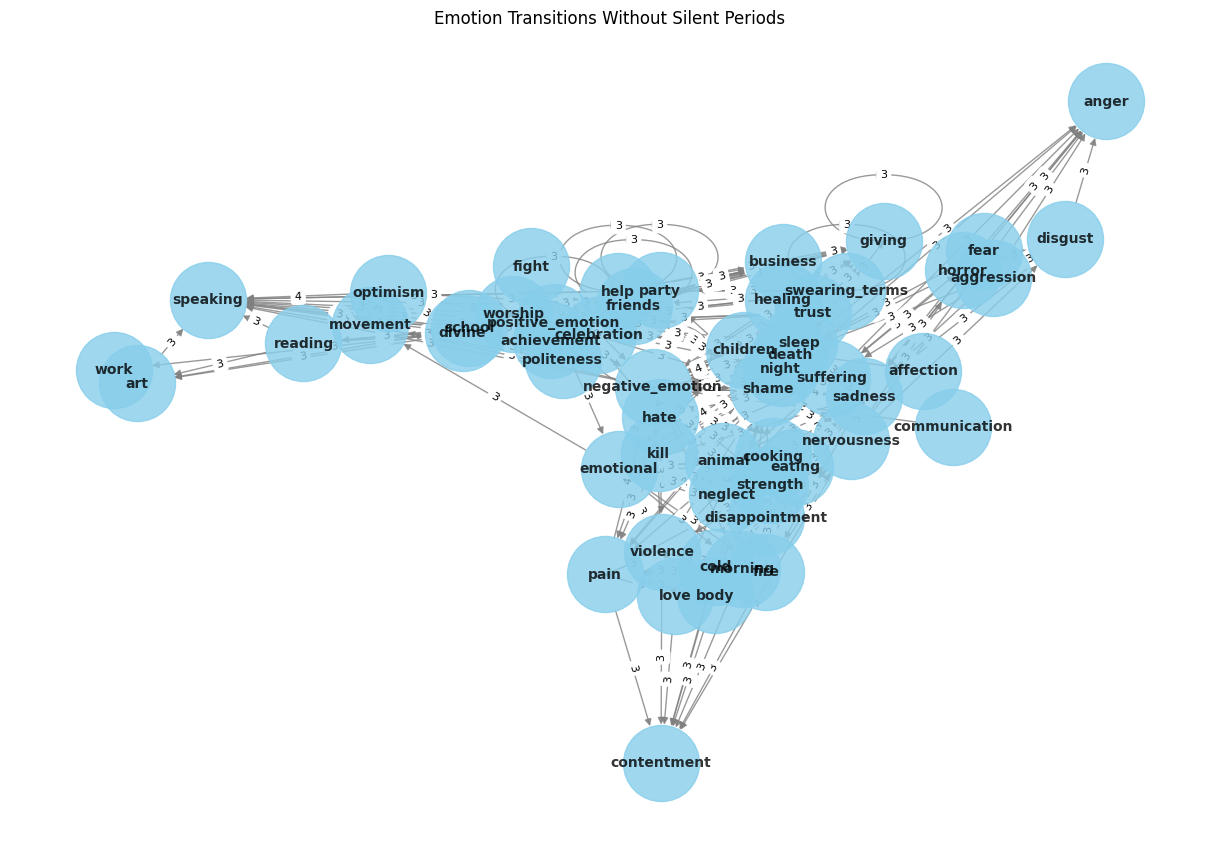

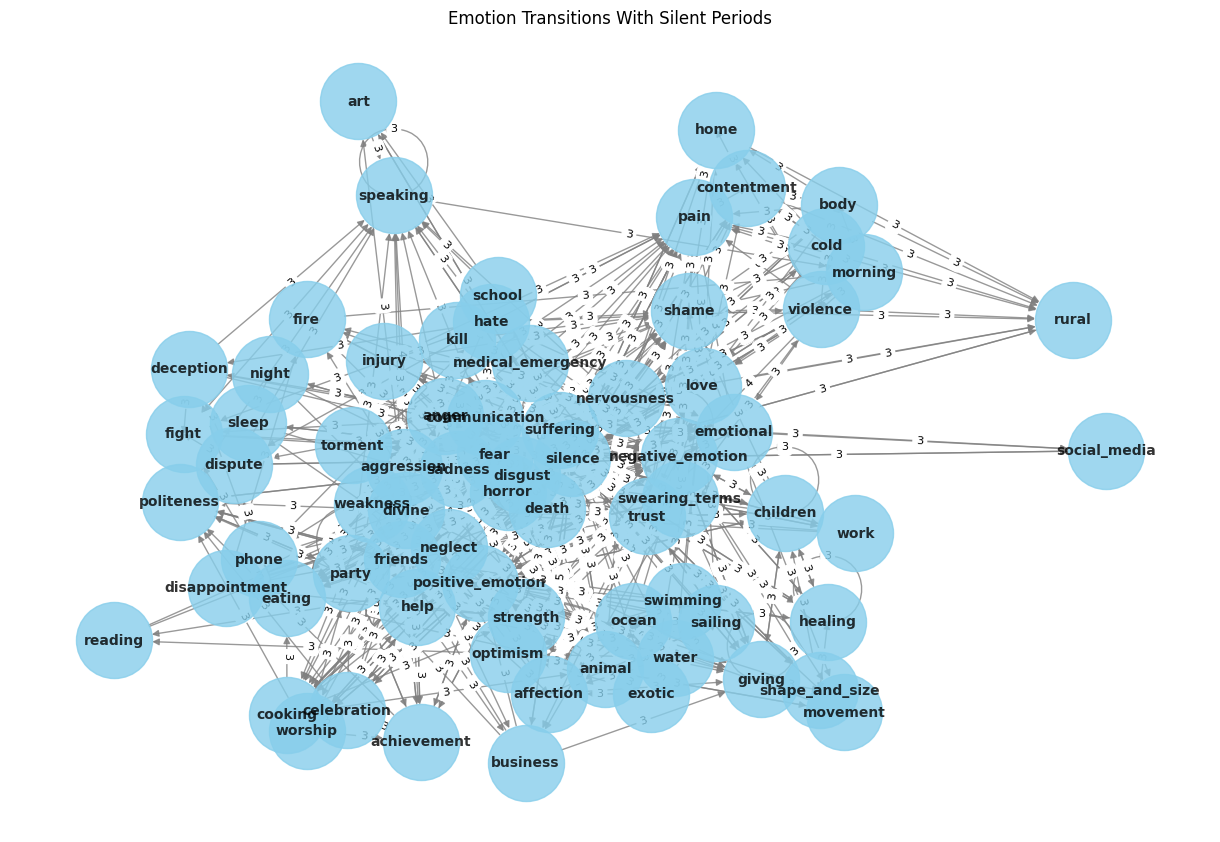

In [35]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_patterns_as_graph(patterns, title):
    G = nx.DiGraph()  # Directed graph

    for window_size, frequent_patterns in patterns.items():
        for support, pattern in frequent_patterns:
            for i in range(len(pattern) - 1):
                G.add_edge(pattern[i], pattern[i + 1], weight=support)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5)
    edges = G.edges(data=True)
    edge_labels = {(u, v): f"{d['weight']}" for u, v, d in edges}

    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=3000, font_size=10, font_weight='bold', alpha=0.8)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(title)
    plt.show()

visualize_patterns_as_graph(patterns_without_silence, "Emotion Transitions Without Silent Periods")
visualize_patterns_as_graph(patterns_with_silence, "Emotion Transitions With Silent Periods")


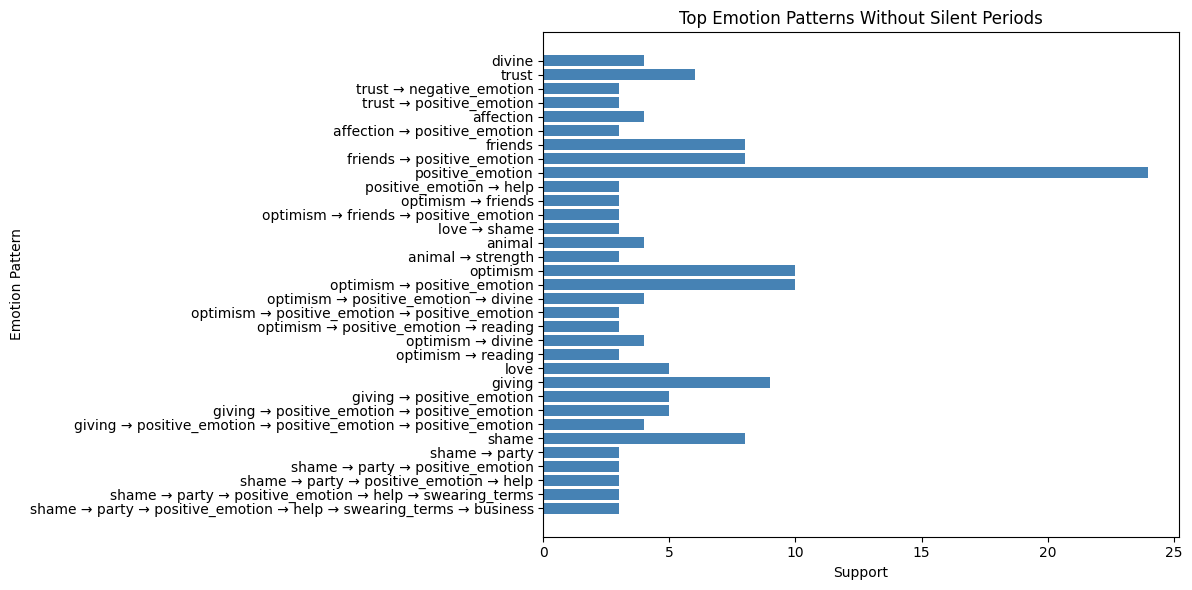

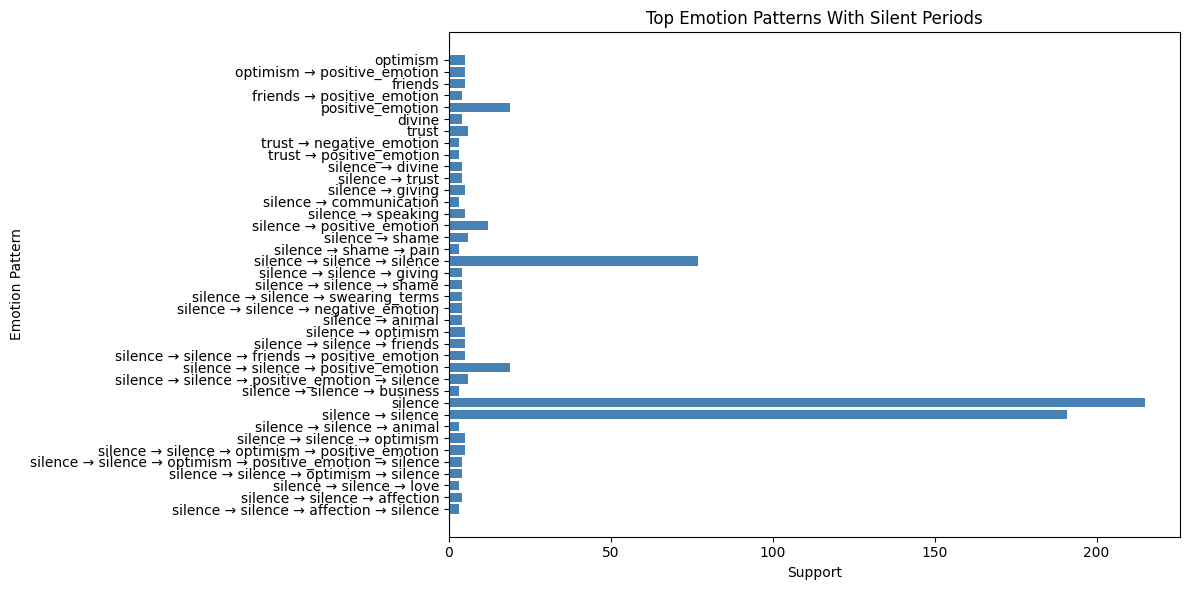

In [34]:
import matplotlib.pyplot as plt

def visualize_top_patterns(patterns, title):
    pattern_labels = []
    pattern_support = []

    for _, frequent_patterns in patterns.items():
        for support, pattern in frequent_patterns[:10]:  # Top 10 patterns
            pattern_labels.append(" → ".join(pattern))
            pattern_support.append(support)

    plt.figure(figsize=(12, 6))
    plt.barh(pattern_labels[::-1], pattern_support[::-1], color="steelblue")  # Reverse for better display
    plt.xlabel("Support")
    plt.ylabel("Emotion Pattern")
    plt.title(title)
    plt.tight_layout()
    plt.show()

visualize_top_patterns(patterns_without_silence, "Top Emotion Patterns Without Silent Periods")
visualize_top_patterns(patterns_with_silence, "Top Emotion Patterns With Silent Periods")


In [32]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [28]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Function to extract patterns from the discovered sequences
def get_sankey_data(patterns):
    links = []
    labels = []
    label_index = {}

    for window_size, frequent_patterns in patterns.items():
        for support, pattern in frequent_patterns[:10]:  # Take top 10 patterns
            for i in range(len(pattern) - 1):
                source, target = pattern[i], pattern[i + 1]

                # Ensure source and target are in labels
                if source not in label_index:
                    label_index[source] = len(labels)
                    labels.append(source)
                if target not in label_index:
                    label_index[target] = len(labels)
                    labels.append(target)

                # Append link data
                links.append({
                    "source": label_index[source],
                    "target": label_index[target],
                    "value": support
                })

    return labels, links

# Extract data for Sankey diagram
labels, links = get_sankey_data(patterns_without_silence)

# Create Sankey diagram using Plotly
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links]
    )
))
# pio.renderers.default = 'iframe'
fig.update_layout(title_text="Emotion Flow in Depression Subreddit (Without Silent Periods)", font_size=12)
fig.show()


In [33]:
# Extract data for Sankey diagram
labels, links = get_sankey_data(patterns_with_silence)

# Create Sankey diagram using Plotly
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links]
    )
))
fig.update_layout(title_text="Emotion Flow in Depression Subreddit (With Silent Periods)", font_size=12)
fig.show()
